In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import scipy.spatial as SS
import matplotlib.pyplot as plt
import math

### Spark cluster

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/02 14:31:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

### Useful functions

In [8]:
# Read data
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    return FoF


# Get masses and positions from FoF
def get_pos_mass(FoF):

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    pos_mass_matrix = np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix


# find pairs by linking radius
def find_pairs_dist(rdd):

    # create pairs (idx, 3D coordinates)
    indexed_rdd = rdd.zipWithIndex()

    # cartesian product between the rdd and itself (to obtain all the possible pairs)
    cartesian_rdd = indexed_rdd.cartesian(indexed_rdd)
    
    # compute distances between every pair
    dist_rdd = cartesian_rdd.map(lambda x: (x[0][1], x[1][1], np.linalg.norm(np.abs(x[0][0] - x[1][0]))))
    
    # filter by linking radius and discard pairs already considered
    dist_rdd_filtered = dist_rdd.filter(lambda x: x[0] < x[1] and x[2] <= 0.2)
    
    return dist_rdd_filtered


# plot a graph in 3D space
def plot_graph_3D(num, pars_file, pos, masses, edge_idx):

    fig = plt.figure(figsize=(10, 10))
    fontsize = 12

    ax = fig.add_subplot(projection ="3d")

    pos = np.array(pos, dtype=float) * 1.e3   # show in Mpc

    # Draw lines for each edge
    for (src, dst) in edge_idx: #.t().tolist():

        src = pos[int(src)].tolist()
        dst = pos[int(dst)].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.6, color='dimgrey')

    # Plot nodes
    mass_mean = np.mean(masses)
    for i,m in enumerate(masses):
            ax.scatter(pos[i, 0], pos[i, 1], pos[i, 2], s=50*m*m/(mass_mean**2), zorder=1000, alpha=0.6, color = 'mediumpurple')

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.zaxis.set_tick_params(labelsize=fontsize)

    ax.set_xlabel('x (Mpc)', fontsize=16, labelpad=15)
    ax.set_ylabel('y (Mpc)', fontsize=16, labelpad=15)
    ax.set_zlabel('z (Mpc)', fontsize=16, labelpad=15)

    rl = '$R_{link} = 0.2$'

    pars_file = pars_file[num]

    ax.set_title(f'\tGraph n°{num}, Masses $\\geq 99.7$% percentile, {rl} Mpc \t \n \n $\\Omega_m = {float(pars_file[0]):.3f}$ \t $\\sigma_8 = {float(pars_file[1]):.3f}$', fontsize=20)

    plt.show()


# Get edge features 
def get_edge_feat(pairs_rdd, distances_rdd, positions_rdd):

    pairs_rdd = pairs_rdd.map(lambda x: x.T)
    rows = pairs_rdd.map(lambda x: x[0]).collect()
    cols = pairs_rdd.map(lambda x: x[1]).collect()

    # centroid of halo catalogue (3d position of the centroid)
    centroid = positions_rdd.mean()

    # distance between each point wrt the centroid
    pos_filtered_rows = positions_rdd.filter(lambda x: x[0] in rows).map(lambda x: x[1])
    pos_filtered_cols = positions_rdd.filter(lambda x: x[0] in cols).map(lambda x: x[1])

    row_rdd = pos_filtered_rows.map(lambda x: x - centroid)
    col_rdd = pos_filtered_cols.map(lambda x: x - centroid)

    # normalizing
    row_rdd = row_rdd.map(lambda x: x/np.linalg.norm(x).reshape(-1,1)).collect()
    col_rdd = col_rdd.map(lambda x: x/np.linalg.norm(x).reshape(-1,1)).collect()
    distances_rdd = distances_rdd.map(lambda x: x/0.2).collect()

    # number of pairs
    n_pairs = pairs_rdd.count()

    # get cosines
    cos1 = np.array([
         np.dot(
              np.array(pos_filtered_rows)[i,:].T,
              np.array(pos_filtered_cols)[i,:]
              ) for i in range(n_pairs)])
    
    cos2 = np.array([np.dot(np.array(pos_filtered_rows)[i,:].T,
                            np.array(distances_rdd)[i,:]) for i in range(n_pairs)])

    # concatenate to get all edge attributes
    edge_attr = np.concatenate([
         np.array(distances_rdd).reshape(-1,1), 
         cos1.reshape(-1,1), 
         cos2.reshape(-1,1)
         ], axis=1)

    return edge_attr

# Get global features
def get_glob_feat(rdd):
    return math.log10(rdd.count())

# Graph object
class graph:

    def __init__(self, node_f, pos, sim_pars, glob_f, edge_idx, edge_f):
        
        self.node_f = node_f
        self.pos = pos
        self.sim_pars = sim_pars
        self.glob_f = glob_f
        self.edge_idx = edge_idx
        self.edge_f = edge_f

In [9]:
# simulations parameter

sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)

In [10]:
# read file and get positions and masses
file_path = "/mnt/cosmo_GNN/Data/" + str(8)
test_FoF = read_cosmo_data(file_path)
pos_mass_array = get_pos_mass(test_FoF)

# mass cut
cut = np.quantile(pos_mass_array[:, 3], 0.997)

# parallelize and filter by mass
pos_mass_rdd = sc.parallelize(pos_mass_array)\
                 .filter(lambda el: el[3] >= cut)

In [11]:
# masses rdd
mass_rdd = pos_mass_rdd.map(lambda x: x[3])

# positions rdd
pos_rdd = pos_mass_rdd.map(lambda el: el[:3])

# pairs and distances rdd
pairs_dist_rdd = find_pairs_dist(pos_rdd)

# pairs rdd
pairs_rdd = pairs_dist_rdd.map(lambda x: (x[0], x[1]))

# distances rdd (filtered)
distances_rdd = pairs_dist_rdd.map(lambda x: x[2])

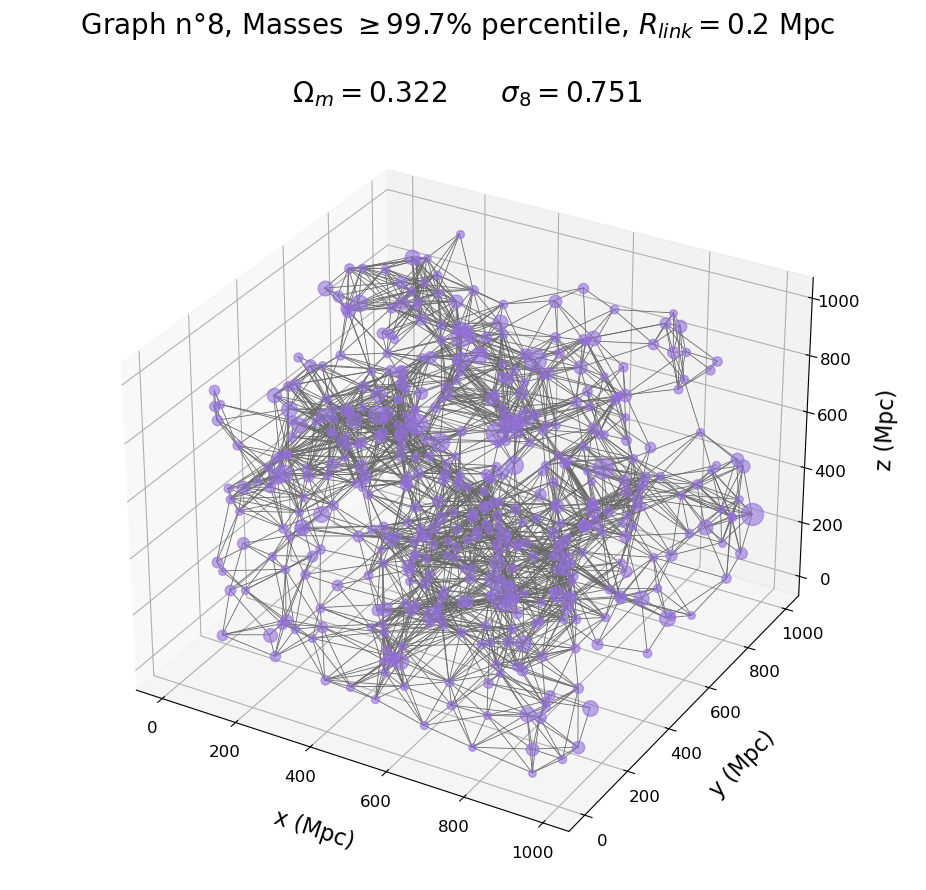

In [12]:
# plot the graph in 3D space

pos_rdd_plot = pos_rdd.collect()
mass_rdd_plot = mass_rdd.collect()
pairs_rdd_plot = pairs_rdd.collect()

plot_graph_3D(8, sim_pars_file, pos_rdd_plot, mass_rdd_plot, pairs_rdd_plot)

In [ ]:
# get edge attributes



In [54]:
sc.stop()
spark.stop()